In [1]:
#Importing Libraries
from Plots import *
from Auxiliar_Functions import *
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import time    
from IPython.display import HTML

In [2]:
def theta_dist(theta,nu_type,case):
    if case==1:
        if nu_type=="nu_e":
            return np.where(theta<-100,0,0.5)
        if nu_type=="nubar_e":
            return np.where(theta<math.pi/3,1,0.25)
    elif case==2:
        if nu_type=="nu_e":
            return np.where(theta<-100,0,0.5)
        if nu_type=="nubar_e":
            return np.where(theta<math.pi/4,1,0.5)
    elif case==3:
        if nu_type=="nu_e":
            return np.where(theta<-100,0,0.5)
        if nu_type=="nubar_e":
            return np.where(theta<math.pi/3,0.5*1.5,0.5)
    else:
        print("Not a valid angular distribution!")

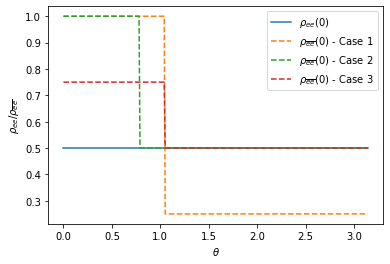

In [3]:
theta_vec=np.arange(0,math.pi,0.01)
plt.plot(theta_vec,theta_dist(theta_vec,"nu_e",1),label=r"$\rho_{ee}(0)$")
plt.plot(theta_vec,theta_dist(theta_vec,"nubar_e",1),ls="--",label=r"$\rho_{\overline{ee}}(0)$ - Case 1")
plt.plot(theta_vec,theta_dist(theta_vec,"nubar_e",2),ls="--",label=r"$\rho_{\overline{ee}}(0)$ - Case 2")
plt.plot(theta_vec,theta_dist(theta_vec,"nubar_e",3),ls="--",label=r"$\rho_{\overline{ee}}(0)$ - Case 3")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\rho_{ee}$/$\rho_{\overline{ee}}$")
plt.legend()
plt.show()

In [40]:
def initiate(nu_types,t_i,t_f,E_nu,mu_0,theta_step,case):
    y0=[] #Initial state
    flavor_sign=1
    omega=delta_m2_31/(2*E_nu*10**6) #eV 

    theta_vec=np.arange(0,np.pi,theta_step)
    n_theta=len(theta_vec)
    n_f=len(nu_types)
    n_dim=(n_f**2)-1

    for i in range(n_theta):        
      for j in range(n_f):
        if nu_types[j]=="nu_x":
#           flavor_sign=-1
          flavor_sign=0

        if nu_types[j]=="nu_e":
          flavor_sign=1
        #nu
        nu_spec=theta_dist(theta_vec[i],"nu_e",case)*theta_step
        y0.append(0)
        y0.append(0)
        y0.append(flavor_sign*nu_spec)
        #nubar
        nu_spec=theta_dist(theta_vec[i],"nubar_e",case)*theta_step
        y0.append(0)
        y0.append(0)
        y0.append(flavor_sign*nu_spec)

    #r array
    t_i = (t_i*3*10**5)*from_eV_to_1_over_km #eV⁻¹
    t_f = (t_f*3*10**5)*from_eV_to_1_over_km #eV⁻¹
    t_step = t_f/1000 #eV⁻¹
    t = np.arange(t_i,t_f,t_step) #eV⁻¹

    return y0,omega,E_nu,t,mu_0,n_f,n_dim,n_theta,theta_vec

In [41]:
t_i,t_f=0,5*10**(-6)
case=1
E_nu=10 #MeV
theta_step=0.01

mu_0=10**3 #km⁻¹
mu_0=mu_0/from_eV_to_1_over_km
nu_types=['nu_e','nu_x']

y0,omega,E,t,mu_0,n_f,n_dim,n_theta,theta_vec=initiate(nu_types,t_i,t_f,E_nu,mu_0,theta_step,case)

In [105]:
def func_Collective_nu_2(y, time, params):
    omega,E,t,mu_0,n_f,n_dim,n_theta,theta_vec= params  # unpack parameters
    B=np.array(B_vec(n_dim,theta_31))
    L=np.array(L_vec(n_dim))
    
#     r=time/from_eV_to_1_over_km #From eV⁻¹ to km
#     mu=mu_supernova(r,mu_opt,mu_0)
    mu=mu_0
    lamb=lambda_supernova(t,"no",0)
    print(time/(3*10**5*from_eV_to_1_over_km))

    derivs=[]
    nu, nubar = [],[]
    num_diff_nu_compnents=2*n_f*n_dim

    #Filling [Theta bin][Nu_types][3components]
    for i in range(n_theta):
      nu.append([])
      nubar.append([])
      for j in range(n_f):
        nu[i].append([])
        nubar[i].append([])
        for k in range(n_dim):
          #nu 
          nu_index=(i*num_diff_nu_compnents)+k+2*j*n_dim
          nu[i][j].append(y[nu_index])
          #nubar   
          nubar_index=(i*num_diff_nu_compnents)+(k+n_dim)+2*j*n_dim
          nubar[i][j].append(y[nubar_index])
    
    #Summed nu and nubar components
    nu_sum, nubar_sum=[],[]
    nu_sum_theta, nubar_sum_theta=[],[]
    nu_aux=np.transpose(nu,(2,0,1))
    nubar_aux=np.transpose(nubar,(2,0,1))

    for i in range(n_dim):
      nu_sum.append(sum(map(sum,nu_aux[i])))
      nubar_sum.append(sum(map(sum,nubar_aux[i])))
#       print(list(map(sum,nu_aux[i])))
#       print(len(map(sum,nu_aux[i])))
      nu_sum_theta.append(sum(theta_vec*list(map(sum,nu_aux[i]))))
      nubar_sum_theta.append(sum(theta_vec*list(map(sum,nubar_aux[i]))))
    
    B=np.array(B)
    nu_sum=np.array(nu_sum)
    nubar_sum=np.array(nubar_sum)
    nu_sum_theta=np.array(nu_sum_theta)
    nubar_sum_theta=np.array(nubar_sum_theta)
    
    # list of dy/dt=f functions
    for i in range(n_theta):
      for j in range(n_f):
        #nu
        aux=B*omega+L*lamb-mu*((nu_sum-nubar_sum)-np.cos(theta_vec[i])*(nu_sum_theta-nubar_sum_theta))
        P_aux= cross_prod(nu[i][j],aux)
        #P_aux= cross_prod(nu[i][j],(B*omega[i]+L*lamb-mu*(nu_sum-nubar_sum)))
        for k in range(n_dim):
          derivs.append(P_aux[k])
        
        #nubar
        aux=-1*B*omega+L*lamb-mu*((nu_sum-nubar_sum)-np.cos(theta_vec[i])*(nu_sum_theta-nubar_sum_theta))
        P_aux= cross_prod(nubar[i][j],aux)
        #P_aux= cross_prod(nubar[i][j],(-1*B*omega[i]+L*lamb-mu*(nu_sum-nubar_sum)))
        for k in range(n_dim):
          derivs.append(P_aux[k])

    return derivs

In [106]:
mass_ord="NH"
y0,omega,E,t,mu_0,n_f,n_dim,n_theta,theta_vec=initiate(nu_types,t_i,t_f,E_nu,mu_0,theta_step,case)

if mass_ord=="NH": 
    params=omega,E,t,mu_0,n_f,n_dim,n_theta,np.array(theta_vec)
elif mass_ord=="IH":
    params=-1*omega,E,t,mu_0,n_f,n_dim,n_theta,np.array(theta_vec)
else:
    print("Not a mass ordering option!")
psoln= odeint(func_Collective_nu_2, y0, t, args=(params,))

0.0
6.103523572471319e-13
6.103523572471319e-13
1.2207047144942637e-12
1.2207047144942637e-12
7.421646864482565e-10
7.421646864482565e-10
1.4831086681820189e-09
1.4831086681820189e-09
2.224052649915781e-09
2.224052649915781e-09
3.366649423277208e-09
3.366649423277208e-09
4.509246196638636e-09
4.509246196638636e-09
5.651842970000063e-09
5.651842970000063e-09
6.794439743361491e-09
6.794439743361491e-09
8.053402283717665e-09
8.053402283717665e-09
9.312364824073836e-09
9.312364824073836e-09
1.0571327364430009e-08
1.0571327364430009e-08
1.1830289904786182e-08
1.1830289904786182e-08
1.3089252445142355e-08
1.3089252445142355e-08
1.4379778677178397e-08
1.4379778677178397e-08
1.5670304909214438e-08
1.5670304909214438e-08
1.696083114125048e-08
1.696083114125048e-08
1.8251357373286524e-08
1.8251357373286524e-08
1.9541883605322566e-08
1.9541883605322566e-08
2.0925572494319485e-08
2.0925572494319485e-08
2.23092613833164e-08
2.23092613833164e-08
2.369295027231332e-08
2.369295027231332e-08
2.50766391

2.6019001318300184e-07
2.6019001318300184e-07
2.616739795822507e-07
2.616739795822507e-07
2.631579459814995e-07
2.631579459814995e-07
2.646419123807484e-07
2.646419123807484e-07
2.6612587877999727e-07
2.6612587877999727e-07
2.676098451792461e-07
2.676098451792461e-07
2.6909381157849496e-07
2.6909381157849496e-07
2.705777779777438e-07
2.705777779777438e-07
2.720617443769927e-07
2.720617443769927e-07
2.7354571077624155e-07
2.7354571077624155e-07
2.750296771754904e-07
2.750296771754904e-07
2.7651364357473924e-07
2.7651364357473924e-07
2.779976099739881e-07
2.779976099739881e-07
2.7948157637323693e-07
2.7948157637323693e-07
2.809655427724858e-07
2.809655427724858e-07
2.8244950917173467e-07
2.8244950917173467e-07
2.839334755709835e-07
2.839334755709835e-07
2.8541744197023236e-07
2.8541744197023236e-07
2.869014083694812e-07
2.869014083694812e-07
2.883853747687301e-07
2.883853747687301e-07
2.8986934116797895e-07
2.8986934116797895e-07
2.913533075672278e-07
2.913533075672278e-07
2.928372739664

5.332398306447911e-07
5.332398306447911e-07
5.3472379704404e-07
5.3472379704404e-07
5.362077634432888e-07
5.362077634432888e-07
5.376917298425377e-07
5.376917298425377e-07
5.391756962417865e-07
5.391756962417865e-07
5.406596626410355e-07
5.406596626410355e-07
5.421436290402843e-07
5.421436290402843e-07
5.436275954395331e-07
5.436275954395331e-07
5.45111561838782e-07
5.45111561838782e-07
5.465955282380308e-07
5.465955282380308e-07
5.480794946372797e-07
5.480794946372797e-07
5.495634610365285e-07
5.495634610365285e-07
5.510474274357774e-07
5.510474274357774e-07
5.525313938350262e-07
5.525313938350262e-07
5.540153602342751e-07
5.540153602342751e-07
5.554993266335239e-07
5.554993266335239e-07
5.569832930327729e-07
5.569832930327729e-07
5.584672594320217e-07
5.584672594320217e-07
5.599512258312705e-07
5.599512258312705e-07
5.614351922305194e-07
5.614351922305194e-07
5.629191586297682e-07
5.629191586297682e-07
5.644031250290171e-07
5.644031250290171e-07
5.658870914282659e-07
5.65887091428265

8.137094801028246e-07
8.137094801028246e-07
8.151934465020735e-07
8.151934465020735e-07
8.166774129013223e-07
8.166774129013223e-07
8.181613793005712e-07
8.181613793005712e-07
8.196453456998201e-07
8.196453456998201e-07
8.21129312099069e-07
8.21129312099069e-07
8.226132784983178e-07
8.226132784983178e-07
8.240972448975667e-07
8.240972448975667e-07
8.255812112968155e-07
8.255812112968155e-07
8.270651776960643e-07
8.270651776960643e-07
8.285491440953132e-07
8.285491440953132e-07
8.30033110494562e-07
8.30033110494562e-07
8.315170768938109e-07
8.315170768938109e-07
8.330010432930597e-07
8.330010432930597e-07
8.344850096923087e-07
8.344850096923087e-07
8.359689760915575e-07
8.359689760915575e-07
8.374529424908064e-07
8.374529424908064e-07
8.389369088900552e-07
8.389369088900552e-07
8.40420875289304e-07
8.40420875289304e-07
8.419048416885529e-07
8.419048416885529e-07
8.433888080878017e-07
8.433888080878017e-07
8.448727744870506e-07
8.448727744870506e-07
8.463567408862994e-07
8.46356740886299

1.0882432639638629e-06
1.0897272303631116e-06
1.0897272303631116e-06
1.0912111967623606e-06
1.0912111967623606e-06
1.0926951631616093e-06
1.0926951631616093e-06
1.0941791295608582e-06
1.0941791295608582e-06
1.0956630959601072e-06
1.0956630959601072e-06
1.097147062359356e-06
1.097147062359356e-06
1.0986310287586049e-06
1.0986310287586049e-06
1.1001149951578536e-06
1.1001149951578536e-06
1.1015989615571026e-06
1.1015989615571026e-06
1.1030829279563513e-06
1.1030829279563513e-06
1.1045668943556003e-06
1.1045668943556003e-06
1.106050860754849e-06
1.106050860754849e-06
1.107534827154098e-06
1.107534827154098e-06
1.109018793553347e-06
1.109018793553347e-06
1.1105027599525956e-06
1.1105027599525956e-06
1.1119867263518446e-06
1.1119867263518446e-06
1.1134706927510933e-06
1.1134706927510933e-06
1.1149546591503423e-06
1.1149546591503423e-06
1.116438625549591e-06
1.116438625549591e-06
1.11792259194884e-06
1.11792259194884e-06
1.1194065583480887e-06
1.1194065583480887e-06
1.1208905247473377e-06
1.

1.3553572158286567e-06
1.3568411822279056e-06
1.3568411822279056e-06
1.3583251486271544e-06
1.3583251486271544e-06
1.3598091150264033e-06
1.3598091150264033e-06
1.3612930814256523e-06
1.3612930814256523e-06
1.362777047824901e-06
1.362777047824901e-06
1.36426101422415e-06
1.36426101422415e-06
1.3657449806233987e-06
1.3657449806233987e-06
1.3672289470226476e-06
1.3672289470226476e-06
1.3687129134218964e-06
1.3687129134218964e-06
1.3701968798211453e-06
1.3701968798211453e-06
1.371680846220394e-06
1.371680846220394e-06
1.373164812619643e-06
1.373164812619643e-06
1.3746487790188918e-06
1.3746487790188918e-06
1.3761327454181407e-06
1.3761327454181407e-06
1.3776167118173897e-06
1.3776167118173897e-06
1.3791006782166384e-06
1.3791006782166384e-06
1.3805846446158873e-06
1.3805846446158873e-06
1.382068611015136e-06
1.382068611015136e-06
1.383552577414385e-06
1.383552577414385e-06
1.3850365438136338e-06
1.3850365438136338e-06
1.3865205102128827e-06
1.3865205102128827e-06
1.3880044766121315e-06
1.

1.6224711676934284e-06
1.6239551340926772e-06
1.6239551340926772e-06
1.625439100491926e-06
1.625439100491926e-06
1.6269230668911747e-06
1.6269230668911747e-06
1.6284070332904234e-06
1.6284070332904234e-06
1.6298909996896721e-06
1.6298909996896721e-06
1.6313749660889207e-06
1.6313749660889207e-06
1.6328589324881694e-06
1.6328589324881694e-06
1.6343428988874181e-06
1.6343428988874181e-06
1.6358268652866669e-06
1.6358268652866669e-06
1.6373108316859156e-06
1.6373108316859156e-06
1.6387947980851641e-06
1.6387947980851641e-06
1.6402787644844129e-06
1.6402787644844129e-06
1.6417627308836616e-06
1.6417627308836616e-06
1.6432466972829104e-06
1.6432466972829104e-06
1.644730663682159e-06
1.644730663682159e-06
1.6462146300814076e-06
1.6462146300814076e-06
1.6476985964806564e-06
1.6476985964806564e-06
1.6491825628799051e-06
1.6491825628799051e-06
1.6506665292791538e-06
1.6506665292791538e-06
1.6521504956784026e-06
1.6521504956784026e-06
1.6536344620776511e-06
1.6536344620776511e-06
1.6551184284768

1.8895851195581943e-06
1.891069085957443e-06
1.891069085957443e-06
1.8925530523566916e-06
1.8925530523566916e-06
1.8940370187559403e-06
1.8940370187559403e-06
1.895520985155189e-06
1.895520985155189e-06
1.8970049515544378e-06
1.8970049515544378e-06
1.8984889179536865e-06
1.8984889179536865e-06
1.899972884352935e-06
1.899972884352935e-06
1.9014568507521838e-06
1.9014568507521838e-06
1.9029408171514325e-06
1.9029408171514325e-06
1.9044247835506813e-06
1.9044247835506813e-06
1.90590874994993e-06
1.90590874994993e-06
1.9073927163491787e-06
1.9073927163491787e-06
1.9088766827484273e-06
1.9088766827484273e-06
1.9103606491476758e-06
1.9103606491476758e-06
1.9118446155469247e-06
1.9118446155469247e-06
1.9133285819461733e-06
1.9133285819461733e-06
1.9148125483454222e-06
1.9148125483454222e-06
1.9162965147446707e-06
1.9162965147446707e-06
1.9177804811439197e-06
1.9177804811439197e-06
1.9192644475431682e-06
1.9192644475431682e-06
1.9207484139424167e-06
1.9207484139424167e-06
1.9222323803416657e-0

2.1626349370199547e-06
2.1626349370199547e-06
2.164118903419203e-06
2.164118903419203e-06
2.1638713714249973e-06
2.1638713714249973e-06
2.16510780583004e-06
2.16510780583004e-06
2.1663442402350824e-06
2.1663442402350824e-06
2.167580674640125e-06
2.167580674640125e-06
2.1688171090451676e-06
2.1688171090451676e-06
2.17005354345021e-06
2.17005354345021e-06
2.171289977855253e-06
2.171289977855253e-06
2.1725264122602954e-06
2.1725264122602954e-06
2.173762846665338e-06
2.173762846665338e-06
2.1749992810703806e-06
2.1749992810703806e-06
2.176235715475423e-06
2.176235715475423e-06
2.1774721498804658e-06
2.1774721498804658e-06
2.1787085842855083e-06
2.1787085842855083e-06
2.1799450186905505e-06
2.1799450186905505e-06
2.181181453095593e-06
2.181181453095593e-06
2.1824178875006357e-06
2.1824178875006357e-06
2.1836543219056783e-06
2.1836543219056783e-06
2.184890756310721e-06
2.184890756310721e-06
2.1861271907157635e-06
2.1861271907157635e-06
2.187363625120806e-06
2.187363625120806e-06
2.1886000595

2.3876659987377027e-06
2.3876659987377027e-06
2.3889024331427453e-06
2.3889024331427453e-06
2.390138867547788e-06
2.390138867547788e-06
2.3913753019528305e-06
2.3913753019528305e-06
2.392611736357873e-06
2.392611736357873e-06
2.3938481707629157e-06
2.3938481707629157e-06
2.3950846051679583e-06
2.3950846051679583e-06
2.396321039573001e-06
2.396321039573001e-06
2.3975574739780435e-06
2.3975574739780435e-06
2.398793908383086e-06
2.398793908383086e-06
2.4000303427881286e-06
2.4000303427881286e-06
2.4012667771931712e-06
2.4012667771931712e-06
2.402503211598214e-06
2.402503211598214e-06
2.4037396460032564e-06
2.4037396460032564e-06
2.404976080408299e-06
2.404976080408299e-06
2.4062125148133416e-06
2.4062125148133416e-06
2.407448949218384e-06
2.407448949218384e-06
2.4086853836234268e-06
2.4086853836234268e-06
2.4099218180284694e-06
2.4099218180284694e-06
2.411158252433512e-06
2.411158252433512e-06
2.4123946868385545e-06
2.4123946868385545e-06
2.413631121243597e-06
2.413631121243597e-06
2.4148

2.613933494860494e-06
2.613933494860494e-06
2.6151699292655364e-06
2.6151699292655364e-06
2.616406363670579e-06
2.616406363670579e-06
2.6176427980756216e-06
2.6176427980756216e-06
2.618879232480664e-06
2.618879232480664e-06
2.6201156668857063e-06
2.6201156668857063e-06
2.621352101290749e-06
2.621352101290749e-06
2.6225885356957915e-06
2.6225885356957915e-06
2.623824970100834e-06
2.623824970100834e-06
2.6250614045058767e-06
2.6250614045058767e-06
2.6262978389109193e-06
2.6262978389109193e-06
2.627534273315962e-06
2.627534273315962e-06
2.6287707077210045e-06
2.6287707077210045e-06
2.630007142126047e-06
2.630007142126047e-06
2.6312435765310897e-06
2.6312435765310897e-06
2.6324800109361322e-06
2.6324800109361322e-06
2.633716445341175e-06
2.633716445341175e-06
2.6349528797462174e-06
2.6349528797462174e-06
2.63618931415126e-06
2.63618931415126e-06
2.6374257485563026e-06
2.6374257485563026e-06
2.638662182961345e-06
2.638662182961345e-06
2.6398986173663878e-06
2.6398986173663878e-06
2.64113505

2.838964556578242e-06
2.8402009909832845e-06
2.8402009909832845e-06
2.841437425388327e-06
2.841437425388327e-06
2.8426738597933697e-06
2.8426738597933697e-06
2.8439102941984122e-06
2.8439102941984122e-06
2.845146728603455e-06
2.845146728603455e-06
2.8463831630084974e-06
2.8463831630084974e-06
2.84761959741354e-06
2.84761959741354e-06
2.8488560318185826e-06
2.8488560318185826e-06
2.850092466223625e-06
2.850092466223625e-06
2.8513289006286678e-06
2.8513289006286678e-06
2.8525653350337104e-06
2.8525653350337104e-06
2.8538017694387525e-06
2.8538017694387525e-06
2.855038203843795e-06
2.855038203843795e-06
2.8562746382488377e-06
2.8562746382488377e-06
2.8575110726538803e-06
2.8575110726538803e-06
2.858747507058923e-06
2.858747507058923e-06
2.8599839414639655e-06
2.8599839414639655e-06
2.861220375869008e-06
2.861220375869008e-06
2.8624568102740507e-06
2.8624568102740507e-06
2.8636932446790933e-06
2.8636932446790933e-06
2.864929679084136e-06
2.864929679084136e-06
2.8661661134891784e-06
2.86616

3.0652320527010325e-06
3.066468487106075e-06
3.066468487106075e-06
3.0677049215111177e-06
3.0677049215111177e-06
3.0689413559161603e-06
3.0689413559161603e-06
3.070177790321203e-06
3.070177790321203e-06
3.0714142247262455e-06
3.0714142247262455e-06
3.072650659131288e-06
3.072650659131288e-06
3.0738870935363307e-06
3.0738870935363307e-06
3.0751235279413733e-06
3.0751235279413733e-06
3.076359962346416e-06
3.076359962346416e-06
3.0775963967514584e-06
3.0775963967514584e-06
3.078832831156501e-06
3.078832831156501e-06
3.0800692655615436e-06
3.0800692655615436e-06
3.081305699966586e-06
3.081305699966586e-06
3.082542134371629e-06
3.082542134371629e-06
3.0837785687766714e-06
3.0837785687766714e-06
3.085015003181714e-06
3.085015003181714e-06
3.0862514375867566e-06
3.0862514375867566e-06
3.087487871991799e-06
3.087487871991799e-06
3.0887243063968413e-06
3.0887243063968413e-06
3.089960740801884e-06
3.089960740801884e-06
3.0911971752069265e-06
3.0911971752069265e-06
3.092433609611969e-06
3.0924336

3.2914995488238236e-06
3.2914995488238236e-06
3.292735983228866e-06
3.292735983228866e-06
3.2939724176339084e-06
3.2939724176339084e-06
3.295208852038951e-06
3.295208852038951e-06
3.2964452864439936e-06
3.2964452864439936e-06
3.297681720849036e-06
3.297681720849036e-06
3.2989181552540787e-06
3.2989181552540787e-06
3.3001545896591213e-06
3.3001545896591213e-06
3.301391024064164e-06
3.301391024064164e-06
3.3026274584692065e-06
3.3026274584692065e-06
3.303863892874249e-06
3.303863892874249e-06
3.3051003272792917e-06
3.3051003272792917e-06
3.3063367616843343e-06
3.3063367616843343e-06
3.307573196089377e-06
3.307573196089377e-06
3.3088096304944195e-06
3.3088096304944195e-06
3.310046064899462e-06
3.310046064899462e-06
3.3112824993045046e-06
3.3112824993045046e-06
3.3125189337095472e-06
3.3125189337095472e-06
3.31375536811459e-06
3.31375536811459e-06
3.3149918025196324e-06
3.3149918025196324e-06
3.316228236924675e-06
3.316228236924675e-06
3.3174646713297176e-06
3.3174646713297176e-06
3.318701

3.5177670449466143e-06
3.5177670449466143e-06
3.519003479351657e-06
3.519003479351657e-06
3.5202399137566995e-06
3.5202399137566995e-06
3.521476348161742e-06
3.521476348161742e-06
3.5227127825667846e-06
3.5227127825667846e-06
3.5239492169718272e-06
3.5239492169718272e-06
3.52518565137687e-06
3.52518565137687e-06
3.5264220857819124e-06
3.5264220857819124e-06
3.5276585201869546e-06
3.5276585201869546e-06
3.528894954591997e-06
3.528894954591997e-06
3.5301313889970398e-06
3.5301313889970398e-06
3.5313678234020823e-06
3.5313678234020823e-06
3.532604257807125e-06
3.532604257807125e-06
3.5338406922121675e-06
3.5338406922121675e-06
3.53507712661721e-06
3.53507712661721e-06
3.5363135610222527e-06
3.5363135610222527e-06
3.5375499954272953e-06
3.5375499954272953e-06
3.538786429832338e-06
3.538786429832338e-06
3.5400228642373805e-06
3.5400228642373805e-06
3.541259298642423e-06
3.541259298642423e-06
3.5424957330474657e-06
3.5424957330474657e-06
3.5437321674525082e-06
3.5437321674525082e-06
3.544968

3.7427981066643623e-06
3.7427981066643623e-06
3.744034541069405e-06
3.744034541069405e-06
3.7452709754744475e-06
3.7452709754744475e-06
3.74650740987949e-06
3.74650740987949e-06
3.7477438442845327e-06
3.7477438442845327e-06
3.7489802786895753e-06
3.7489802786895753e-06
3.750216713094618e-06
3.750216713094618e-06
3.7514531474996605e-06
3.7514531474996605e-06
3.752689581904703e-06
3.752689581904703e-06
3.7539260163097457e-06
3.7539260163097457e-06
3.7551624507147882e-06
3.7551624507147882e-06
3.756398885119831e-06
3.756398885119831e-06
3.7576353195248734e-06
3.7576353195248734e-06
3.758871753929916e-06
3.758871753929916e-06
3.7601081883349586e-06
3.7601081883349586e-06
3.761344622740001e-06
3.761344622740001e-06
3.7625810571450434e-06
3.7625810571450434e-06
3.763817491550086e-06
3.763817491550086e-06
3.7650539259551285e-06
3.7650539259551285e-06
3.766290360360171e-06
3.766290360360171e-06
3.7675267947652137e-06
3.7675267947652137e-06
3.7687632291702563e-06
3.7687632291702563e-06
3.769999

3.971538471597238e-06
3.972774906002281e-06
3.972774906002281e-06
3.974011340407323e-06
3.974011340407323e-06
3.975247774812366e-06
3.975247774812366e-06
3.9764842092174085e-06
3.9764842092174085e-06
3.977720643622451e-06
3.977720643622451e-06
3.978957078027494e-06
3.978957078027494e-06
3.980193512432536e-06
3.980193512432536e-06
3.981429946837579e-06
3.981429946837579e-06
3.9826663812426215e-06
3.9826663812426215e-06
3.983902815647664e-06
3.983902815647664e-06
3.985139250052707e-06
3.985139250052707e-06
3.986375684457749e-06
3.986375684457749e-06
3.987612118862792e-06
3.987612118862792e-06
3.9888485532678344e-06
3.9888485532678344e-06
3.990084987672877e-06
3.990084987672877e-06
3.99132142207792e-06
3.99132142207792e-06
3.992557856482962e-06
3.992557856482962e-06
3.993794290888005e-06
3.993794290888005e-06
3.995030725293047e-06
3.995030725293047e-06
3.99626715969809e-06
3.99626715969809e-06
3.997503594103133e-06
3.997503594103133e-06
3.998740028508175e-06
3.998740028508175e-06
3.999976

4.202751705340199e-06
4.202751705340199e-06
4.203988139745242e-06
4.203988139745242e-06
4.205224574150284e-06
4.205224574150284e-06
4.206461008555327e-06
4.206461008555327e-06
4.2076974429603696e-06
4.2076974429603696e-06
4.208933877365412e-06
4.208933877365412e-06
4.210170311770455e-06
4.210170311770455e-06
4.211406746175497e-06
4.211406746175497e-06
4.21264318058054e-06
4.21264318058054e-06
4.2138796149855825e-06
4.2138796149855825e-06
4.215116049390625e-06
4.215116049390625e-06
4.216352483795668e-06
4.216352483795668e-06
4.21758891820071e-06
4.21758891820071e-06
4.218825352605753e-06
4.218825352605753e-06
4.2200617870107955e-06
4.2200617870107955e-06
4.221298221415838e-06
4.221298221415838e-06
4.222534655820881e-06
4.222534655820881e-06
4.223771090225923e-06
4.223771090225923e-06
4.225007524630966e-06
4.225007524630966e-06
4.226243959036008e-06
4.226243959036008e-06
4.227480393441051e-06
4.227480393441051e-06
4.228716827846094e-06
4.228716827846094e-06
4.229953262251136e-06
4.229953

4.432728504678118e-06
4.432728504678118e-06
4.43396493908316e-06
4.43396493908316e-06
4.435201373488203e-06
4.435201373488203e-06
4.436437807893245e-06
4.436437807893245e-06
4.437674242298288e-06
4.437674242298288e-06
4.438910676703331e-06
4.438910676703331e-06
4.440147111108373e-06
4.440147111108373e-06
4.441383545513416e-06
4.441383545513416e-06
4.442619979918458e-06
4.442619979918458e-06
4.443856414323501e-06
4.443856414323501e-06
4.4450928487285435e-06
4.4450928487285435e-06
4.446329283133586e-06
4.446329283133586e-06
4.447565717538629e-06
4.447565717538629e-06
4.448802151943671e-06
4.448802151943671e-06
4.450038586348714e-06
4.450038586348714e-06
4.4512750207537565e-06
4.4512750207537565e-06
4.452511455158799e-06
4.452511455158799e-06
4.453747889563842e-06
4.453747889563842e-06
4.454984323968884e-06
4.454984323968884e-06
4.456220758373927e-06
4.456220758373927e-06
4.4574571927789694e-06
4.4574571927789694e-06
4.458693627184012e-06
4.458693627184012e-06
4.459930061589055e-06
4.4599

4.663941738421079e-06
4.665178172826121e-06
4.665178172826121e-06
4.666414607231164e-06
4.666414607231164e-06
4.667651041636206e-06
4.667651041636206e-06
4.668887476041249e-06
4.668887476041249e-06
4.670123910446292e-06
4.670123910446292e-06
4.671360344851334e-06
4.671360344851334e-06
4.672596779256377e-06
4.672596779256377e-06
4.673833213661419e-06
4.673833213661419e-06
4.675069648066462e-06
4.675069648066462e-06
4.6763060824715045e-06
4.6763060824715045e-06
4.677542516876547e-06
4.677542516876547e-06
4.67877895128159e-06
4.67877895128159e-06
4.680015385686632e-06
4.680015385686632e-06
4.681251820091675e-06
4.681251820091675e-06
4.6824882544967175e-06
4.6824882544967175e-06
4.68372468890176e-06
4.68372468890176e-06
4.684961123306803e-06
4.684961123306803e-06
4.686197557711845e-06
4.686197557711845e-06
4.687433992116888e-06
4.687433992116888e-06
4.6886704265219305e-06
4.6886704265219305e-06
4.689906860926973e-06
4.689906860926973e-06
4.691143295332016e-06
4.691143295332016e-06
4.692379

4.89515497216404e-06
4.896391406569082e-06
4.896391406569082e-06
4.897627840974125e-06
4.897627840974125e-06
4.8988642753791674e-06
4.8988642753791674e-06
4.90010070978421e-06
4.90010070978421e-06
4.901337144189253e-06
4.901337144189253e-06
4.902573578594295e-06
4.902573578594295e-06
4.903810012999338e-06
4.903810012999338e-06
4.90504644740438e-06
4.90504644740438e-06
4.906282881809423e-06
4.906282881809423e-06
4.9075193162144656e-06
4.9075193162144656e-06
4.908755750619508e-06
4.908755750619508e-06
4.909992185024551e-06
4.909992185024551e-06
4.911228619429593e-06
4.911228619429593e-06
4.912465053834636e-06
4.912465053834636e-06
4.9137014882396785e-06
4.9137014882396785e-06
4.914937922644721e-06
4.914937922644721e-06
4.916174357049764e-06
4.916174357049764e-06
4.917410791454806e-06
4.917410791454806e-06
4.918647225859849e-06
4.918647225859849e-06
4.9198836602648915e-06
4.9198836602648915e-06
4.921120094669934e-06
4.921120094669934e-06
4.922356529074977e-06
4.922356529074977e-06
4.92359

In [49]:
def func_Collective_nu(y, time, params):
    omega,E,t,mu_0,n_f,n_dim,n_theta,theta_vec= params  # unpack parameters
    B=np.array(B_vec(n_dim,theta_31))
    L=np.array(L_vec(n_dim))
    
#     r=time/from_eV_to_1_over_km #From eV⁻¹ to km
#     mu=mu_supernova(r,mu_opt,mu_0)
    mu=mu_0
    lamb=lambda_supernova(time,"no",0)
    print(time/(3*10**5*from_eV_to_1_over_km))
    
    derivs=[]
    nu, nubar = [],[]
    num_diff_nu_compnents=2*n_f*n_dim

    #Filling [Theta bin][Nu_types][3components]
    for i in range(n_theta):
      nu.append([])
      nubar.append([])
      for j in range(n_f):
        nu[i].append([])
        nubar[i].append([])
        for k in range(n_dim):
          #nu 
          nu_index=(i*num_diff_nu_compnents)+k+2*j*n_dim
          nu[i][j].append(y[nu_index])
          #nubar   
          nubar_index=(i*num_diff_nu_compnents)+(k+n_dim)+2*j*n_dim
          nubar[i][j].append(y[nubar_index])
    
    #Summed nu and nubar components
    nu_sum, nubar_sum=[],[]
    nu_sum_theta, nubar_sum_theta=[],[]
    nu_aux=np.transpose(nu,(2,1,0))
    nubar_aux=np.transpose(nubar,(2,1,0))

    for i in range(n_dim):
        nu_sum_aux=0
        nubar_sum_aux=0
        nu_sum_theta_aux=0
        nubar_sum_theta_aux=0
        for j in range(n_f):
            for k in range(n_theta):
                nu_sum_aux+=nu[k][j][i]
                nubar_sum_aux+=nubar[k][j][i]
                nu_sum_theta_aux+=np.cos(theta_vec[k])*nu[k][j][i]
                nubar_sum_theta_aux+=np.cos(theta_vec[k])*nubar[k][j][i]
        nu_sum.append(nu_sum_aux)
        nubar_sum.append(nubar_sum_aux)
        nu_sum_theta.append(nu_sum_theta_aux)
        nubar_sum_theta.append(nubar_sum_theta_aux)
    
    B=np.array(B)
    nu_sum=np.array(nu_sum)
    nubar_sum=np.array(nubar_sum)
    nu_sum_theta=np.array(nu_sum_theta)
    nubar_sum_theta=np.array(nubar_sum_theta)
    
    # list of dy/dt=f functions
    for i in range(n_theta):
      for j in range(n_f):
        #nu
        aux=B*omega+L*lamb-mu*((nu_sum-nubar_sum)-np.cos(theta_vec[i])*(nu_sum_theta-nubar_sum_theta))
        P_aux= cross_prod(nu[i][j],aux)
        #P_aux= cross_prod(nu[i][j],(B*omega[i]+L*lamb-mu*(nu_sum-nubar_sum)))
        for k in range(n_dim):
          derivs.append(P_aux[k])
        
        #nubar
        aux=-1*B*omega+L*lamb-mu*((nu_sum-nubar_sum)-np.cos(theta_vec[i])*(nu_sum_theta-nubar_sum_theta))
        P_aux= cross_prod(nubar[i][j],aux)
        #P_aux= cross_prod(nubar[i][j],(-1*B*omega[i]+L*lamb-mu*(nu_sum-nubar_sum)))
        for k in range(n_dim):
          derivs.append(P_aux[k])

    return derivs

In [ ]:
mass_ord="IH"
y0,omega,E,t,mu_0,n_f,n_dim,n_theta,theta_vec=initiate(nu_types,t_i,t_f,E_nu,mu_0,theta_step,case)

if mass_ord=="NH": 
    params=omega,E,t,mu_0,n_f,n_dim,n_theta,np.array(theta_vec)
elif mass_ord=="IH":
    params=-1*omega,E,t,mu_0,n_f,n_dim,n_theta,np.array(theta_vec)
else:
    print("Not a mass ordering option!")
psoln= odeint(func_Collective_nu_2, y0, t, args=(params,))

In [107]:
nu, nubar= read_output(psoln,(n_f,n_dim,n_theta))

In [109]:
nu_e_time,nubar_e_time,nu_x_time,nubar_x_time=read_two_flavor_v1(nu, nubar)

In [118]:
nu[2][0][0]

[0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,


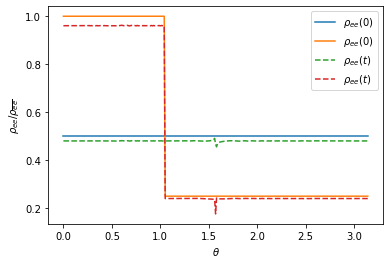

In [122]:
theta_vec=np.arange(0,np.pi,theta_step)
plt.plot(theta_vec,np.array(nu[2][0][0])/theta_step,label=r"$\rho_{ee}(0)$")
plt.plot(theta_vec,np.array(nubar[2][0][0])/theta_step,label=r"$\rho_{ee}(0)$")
plt.plot(theta_vec,np.array(nu[2][0][-1])/theta_step,ls='--',label=r"$\rho_{ee}(t)$")
plt.plot(theta_vec,np.array(nubar[2][0][-1])/theta_step,ls='--',label=r"$\rho_{ee}(t)$")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\rho_{ee}$/$\rho_{\overline{ee}}$")
plt.legend()
plt.show()

In [145]:
  nu_e_time,nubar_e_time=[],[]
  nu_x_time,nubar_x_time=[],[]

  for l in range(len(nu[0][0])): #time array length
      nu_e_time.append([])
      nubar_e_time.append([])
      nu_x_time.append([])
      nubar_x_time.append([])
    
      for i in range(len(nu[0][0][0])): 
        #nu
        Pee=(1/2)*(1+nu[2][0][l][i]/nu[2][0][0][i])
        Pxx=(1/2)*(1+nu[2][1][l][i]/nu[2][1][0][i])
        if Pxx!=Pxx:
            Pxx=1

        nu_e_time[l].append(Pee*nu[2][0][0][i]+(1-Pxx)*(-1)*nu[2][1][0][i])
        nu_x_time[l].append(Pxx*(-1)*nu[2][1][0][i]+(1-Pee)*nu[2][0][0][i])

        #nubar
        Pee=(1/2)*(1+nubar[2][0][l][i]/nubar[2][0][0][i])
        Pxx=(1/2)*(1+nubar[2][1][l][i]/nubar[2][1][0][i])
        if Pxx!=Pxx:
            Pxx=1

        nubar_e_time[l].append(Pee*nubar[2][0][0][i]+(1-Pxx)*(-1)*nubar[2][1][0][i])
        nubar_x_time[l].append(Pxx*(-1)*nubar[2][1][0][i]+(1-Pee)*nubar[2][0][0][i])

/tmp/ipykernel_6662/1225073773.py:13: RuntimeWarning: invalid value encountered in double_scalars
  Pxx=(1/2)*(1+nu[2][1][l][i]/nu[2][1][0][i])
/tmp/ipykernel_6662/1225073773.py:22: RuntimeWarning: invalid value encountered in double_scalars
  Pxx=(1/2)*(1+nubar[2][1][l][i]/nubar[2][1][0][i])
